In [1]:

#6
from __future__ import print_function

import sys
import os
import time
import string
import random
import pickle

import numpy as np
import theano
import theano.tensor as T
import lasagne

# for the larger networks (n>=9), we need to adjust pythons recursion limit
sys.setrecursionlimit(10000)

# ##################### Load data from CIFAR-10 dataset #######################
# this code assumes the cifar dataset from 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# has been extracted in current working directory
import _pickle
def unpickle(file):
    fo = open(file, 'rb')
    dict = _pickle.load(fo,encoding='iso-8859-1')
    fo.close()
    return dict

def load_data():
    xs = []
    ys = []
    for j in range(5):
      d = unpickle('cifar-10-batches-py/data_batch_'+str(j+1))
      x = d['data']
      y = d['labels']
      xs.append(x)
      ys.append(y)

    x = np.concatenate(xs)
    y = np.concatenate(ys).astype(np.int32)
    print("1. x.shape = ",x.shape)                             # x.shape =  (50000, 3072)
    print("2. len of  y = ",len(y))                            # len of  y =  50000      
    
    d = unpickle('cifar-10-batches-py/test_batch')
    x_test = d['data']
    y_test = np.array(d['labels'],dtype=np.int32)
    
    X_train = np.reshape(x, (x.shape[0], -1))    
    X_test = np.reshape(x_test, (x_test.shape[0], -1))
    print("3. X_train.shape = ",X_train.shape)                 # X_train.shape =  (50000, 3072)
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train,axis = 0)
    #X_train -= mean_image.astype(X_train.dtype)
    #X_test -= mean_image.astype(X_test.dtype)
    X_train = X_train / 255
    X_test = X_test / 255  
  
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    print("4. X_train.shape after  = ",X_train.shape)          # X_train.shape after  =  (50000, 3073)
    
    return X_train, y,  X_test, y_test

C:\Users\Rashmi\Anaconda3\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [37]:
# 6.1. 4.2 Split data into 80:20
import pandas as pd
import random
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

def split_data(X,y,test_proportion):
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=test_proportion, random_state=0)
    print(X_train.shape, y_train.shape)
    return X_train, X_Val, y_train, y_Val; 
#X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train.shape, y_train.shape

In [38]:
X, y, X_test, y_test = load_data()

1. x.shape =  (50000, 3072)
2. len of  y =  50000
3. X_train.shape =  (50000, 3072)
4. X_train.shape after  =  (50000, 3073)


In [151]:
def logistic_loss(W, b, X, y):
    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 
    scores = scores/scores.max()
    # compute the class probability
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]  # How do we deal if there is only one output 
    
    num_examples = len(X)
    #print(num_examples)
    #print(probs[range(num_examples),y])
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    #print("corect_logprobs shape : ",corect_logprobs.shape)
    #print(y)
    #print("corect_logprobs shape : ",corect_logprobs.shape)
    data_loss = np.sum(corect_logprobs)/num_examples
    #print("data_loss shape : ",data_loss.shape)
    
    return data_loss;
    
# 3.2. Write a function to compute the multiclass SVM loss given the parameters (W; b)
# of a linear model (as numpy arrays) and an example (x; y).

def multiClass_SVM_Loss(W, b, X, y):
    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 
    correct_scores = scores[range(num_examples),y]
    
    loss = scores - correct_scores + np.ones[scores.shape]
    loss[loss<0] = 0
    loss[range(num_examples),y] = 0
    svm_loss = np.sum(loss)
    return svm_loss
    
    
# 3.3 Add an `1 regularization and an `2 regularization to the loss function.
# Can I add the regularization term separately ? 0.5*Lambda*W^2 and 0.5*Lambda*W

def logistic_loss_lasso(W,b,X,y,reg):
    data_loss = logistic_loss(W, b, X, y)
    reg_loss = 0.5*reg*np.sum(W)
    data_loss = data_loss + reg_loss
    return data_loss

def logistic_loss_ridge(W,b,X,y,reg):
    data_loss = logistic_loss(W, b, X, y)
    reg_loss = 0.5*reg*np.sum(W*W)
    data_loss = data_loss + reg_loss
    return data_loss

In [155]:
# 6.2 4.3 Linear Classifier [Alternate Method] without regularization

def linear_classifier_WR(X_train,y_train,W,b,learning_rate,num_iter):
    #reg = 0.0001
    #learning_rate = 0.1
    
    for i in range(num_iter):
        scores = np.dot(X_train,W)+ b
        scores = scores/scores.max()
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
        
    
        loss = logistic_loss(W,b,X_train,y_train)
        #loss = logistic_loss(W,b,X_train,y_train)
        if i % 10 == 0:
            print("iteration:",i, " loss:",loss)
  
        num_examples = len(X_train)
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples
  
        # backpropate the gradient to the parameters (W,b)
        dW = np.dot(X_train.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
  
        #dW += reg*W # regularization gradient
  
        # perform a parameter update
        W += -learning_rate * dW
        b += -learning_rate * db
    return W,b,loss;


In [ ]:
# 6.2 4.3 Linear Classifier [Alternate Method]

def linear_classifier(X_train,y_train,W,b,reg,learning_rate,num_iter):
    #reg = 0.0001
    #learning_rate = 0.1
    
    for i in range(num_iter):
        scores = np.dot(X_train,W)+ b
        scores = scores/scores.max()
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
        
    
        loss = logistic_loss_ridge(W,b,X_train,y_train,reg)
        #loss = logistic_loss(W,b,X_train,y_train)
        if i % 10 == 0:
            print("iteration:",i, " loss:",loss)
  
        num_examples = len(X_train)
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples
  
        # backpropate the gradient to the parameters (W,b)
        dW = np.dot(X_train.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)
  
        dW += reg*W # regularization gradient
  
        # perform a parameter update
        W += -learning_rate * dW
        b += -learning_rate * db
    return W,b,loss;


In [43]:
test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

D = X_train.shape[1]     # 28*28
k = int(max(y_train)+ 1) # 10
W = 0.1*np.random.randn(D,k)   # How do you declare a D*K matrix ??? Be careful !!!
b = 0.1*np.zeros((1,k))
W,b,loss = linear_classifier(X_train,y_train,W,b,0.1,50)    
    # Performance check
    
y_hat_train = np.argmax((np.dot(X_train, W)+b), axis = 1)
training_precision = np.mean(y_hat_train == y_train)

y_hat_test = np.argmax((np.dot(X_Val, W)+b), axis = 1)
test_precision = np.mean(y_hat_test == y_Val)
    
#print("batch: ",i, " | Loss: ",loss)
#print("### Exiting batch execution")
print("Accuracy train = ",training_precision," | test = ",test_precision)


(40000, 3073) (40000,)
iteration: 0  loss: 2.35155313084
iteration: 10  loss: 2.24126868123
iteration: 20  loss: 2.22103410973
iteration: 30  loss: 2.21711011217
iteration: 40  loss: 2.21553270419
Accuracy train =  0.244  | test =  0.2472


In [156]:
#Without Regularization
test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

D = X_train.shape[1]     # 28*28
k = int(max(y_train)+ 1) # 10
W = 0.1*np.random.randn(D,k)   # How do you declare a D*K matrix ??? Be careful !!!
b = 0.1*np.zeros((1,k))
W,b,loss = linear_classifier_WR(X_train,y_train,W,b,0.1,50)    
    # Performance check
    
y_hat_train = np.argmax((np.dot(X_train, W)+b), axis = 1)
training_precision = np.mean(y_hat_train == y_train)

y_hat_test = np.argmax((np.dot(X_Val, W)+b), axis = 1)
test_precision = np.mean(y_hat_test == y_Val)
    
#print("batch: ",i, " | Loss: ",loss)
#print("### Exiting batch execution")
print("Accuracy train = ",training_precision," | test = ",test_precision)


(40000, 3073) (40000,)
iteration: 0  loss: 2.32420367313
iteration: 10  loss: 2.22429103398
iteration: 20  loss: 2.19377555452
iteration: 30  loss: 2.19058713529
iteration: 40  loss: 2.19222301191
Accuracy train =  0.24875  | test =  0.2488


In [45]:
# 6.2. 4.4 Cross validation justification 

from sklearn import cross_validation
cv = cross_validation.KFold(len(X_train), n_folds=3, shuffle=True) # 43200 & 4800 each
j = 0
for train_indices, test_indices in cv:
    # N-1 Folds
    X_train_temp = X_train[train_indices]
    y_train_temp = y_train[train_indices]
    # The remaining 1 fold
    X_test_temp = X_train[test_indices]
    y_test_temp = y_train[test_indices]
    
    print("#### CV ",j)
    j = j + 1
    D = X_train_temp.shape[1]     # 28*28
    k = int(max(y_train_temp)+ 1) # 10
    W = 0.1*np.random.randn(D,k)   # How do you declare a D*K matrix ??? Be careful !!!
    b = 0.1*np.zeros((1,k))
    print("### Entering batch execution")
    W,b,loss = linear_classifier(X_train_temp,y_train_temp,W,b,0.0001,0.1,50)    
    # Performance check

    y_hat_train = np.argmax((np.dot(X_train_temp, W)+b), axis = 1)
    training_precision = np.mean(y_hat_train == y_train_temp)

    y_hat_test = np.argmax((np.dot(X_test_temp, W)+b), axis = 1)
    test_precision = np.mean(y_hat_test == y_test_temp)

        #print("batch: ",i, " | Loss: ",loss)
    #print("### Exiting batch execution")
    print("Accuracy train = ",training_precision," | test = ",test_precision)

#### CV  0
### Entering batch execution
iteration: 0  loss: 2.33604542974
iteration: 10  loss: 2.25903911252
iteration: 20  loss: 2.23521466834
iteration: 30  loss: 2.225190404
iteration: 40  loss: 2.22007786306
Accuracy train =  0.246081152029  | test =  0.248237588121
#### CV  1
### Entering batch execution
iteration: 0  loss: 2.35776663367
iteration: 10  loss: 2.25103939927
iteration: 20  loss: 2.22027814311
iteration: 30  loss: 2.20624803371
iteration: 40  loss: 2.20412736941
Accuracy train =  0.257134285821  | test =  0.252306307658
#### CV  2
### Entering batch execution
iteration: 0  loss: 2.32880270666
iteration: 10  loss: 2.23900093068
iteration: 20  loss: 2.22180697764
iteration: 30  loss: 2.21294711241
iteration: 40  loss: 2.20959469113
Accuracy train =  0.245396932538  | test =  0.237155928898


In [46]:
def my_own_batch_sgd(X_train,y_train,reg,learning_rate,num_iter): 
    D = X_train.shape[1]     # 28*28
    k = int(max(y_train)+ 1) # 10
    W = 0.1*np.random.randn(D,k)   # How do you declare a D*K matrix ??? Be careful !!!
    b = 0.1*np.zeros((1,k))
    W,b,loss = linear_classifier(X_train,y_train,W,b,reg,learning_rate,num_iter)    
        # Performance check
    #print("### Exiting batch execution")
    return W,b,loss;

iteration: 0  loss: 2.33929028986
iteration: 10  loss: 2.3365024023
iteration: 20  loss: 2.33368163061
iteration: 30  loss: 2.33059079426
iteration: 40  loss: 2.32773340153
iteration: 0  loss: 2.35324781517
iteration: 10  loss: 2.21803231953
iteration: 20  loss: 2.22517216921
iteration: 30  loss: 2.23752360369
iteration: 40  loss: 2.25513871203
iteration: 0  loss: 2.33549920518
iteration: 10  loss: 2.22489895942
iteration: 20  loss: 2.25475501338
iteration: 30  loss: 2.30609190594
iteration: 40  loss: 2.37684246242
iteration: 0  loss: 2.35035383436
iteration: 10  loss: 2.23695381697
iteration: 20  loss: 2.30779750418
iteration: 30  loss: 2.42241787068
iteration: 40  loss: 2.58037299966


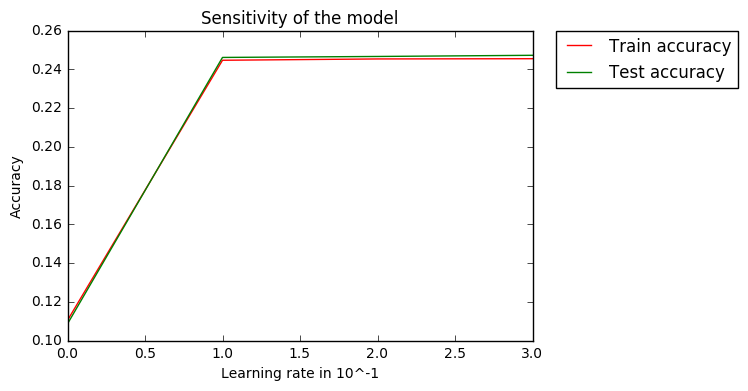

In [127]:
# 6.2. 4.5 sensitivity of the model's performance to different learning rates !!

j = 0
train_acc = []
test_acc = []
for i in range(1, 4000, 1000):
    W,b,loss = my_own_batch_sgd(X_train,y_train,0.0001,i/1000,50)
    # Performance check
    y_hat_train = np.argmax((np.dot(X_train, W)+b), axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    
    y_hat_test = np.argmax((np.dot(X_test, W)+b), axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    #print("# of Iterations = ",i," | Accuracy train = ",training_precision, " | Accuracy test = ",test_precision)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)
    
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Learning rate in 10^-1")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

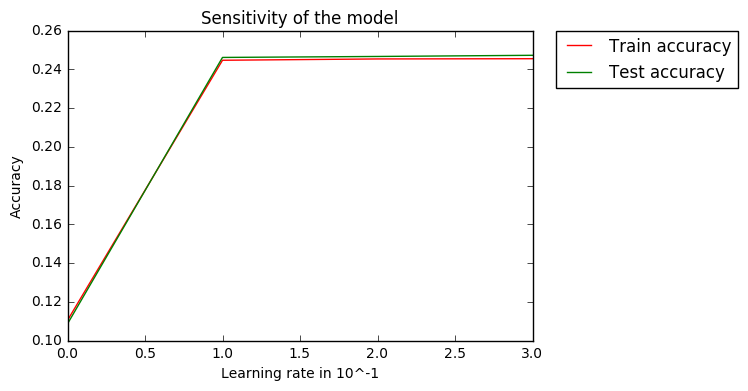

In [130]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Learning rate in 10^-1")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

(40000, 3073) (40000,)
iteration: 0  loss: 2.33982224052
iteration: 0  loss: 2.34148704089
iteration: 10  loss: 2.25546989404
iteration: 20  loss: 2.23763975168
iteration: 30  loss: 2.22994643477
iteration: 40  loss: 2.22581339242
iteration: 50  loss: 2.2233374417
iteration: 60  loss: 2.22177389077
iteration: 70  loss: 2.22077401862
iteration: 80  loss: 2.22015361593
iteration: 90  loss: 2.21980654205
iteration: 100  loss: 2.21966747911
iteration: 0  loss: 2.35810434902
iteration: 10  loss: 2.24069230748
iteration: 20  loss: 2.21460261593
iteration: 30  loss: 2.20409186665
iteration: 40  loss: 2.20433893794
iteration: 50  loss: 2.20608276972
iteration: 60  loss: 2.20738047731
iteration: 70  loss: 2.20843113833
iteration: 80  loss: 2.20934353635
iteration: 90  loss: 2.21017983422
iteration: 100  loss: 2.21097779231
iteration: 110  loss: 2.2117615506
iteration: 120  loss: 2.21254720793
iteration: 130  loss: 2.213345886
iteration: 140  loss: 2.21416550023
iteration: 150  loss: 2.215011828

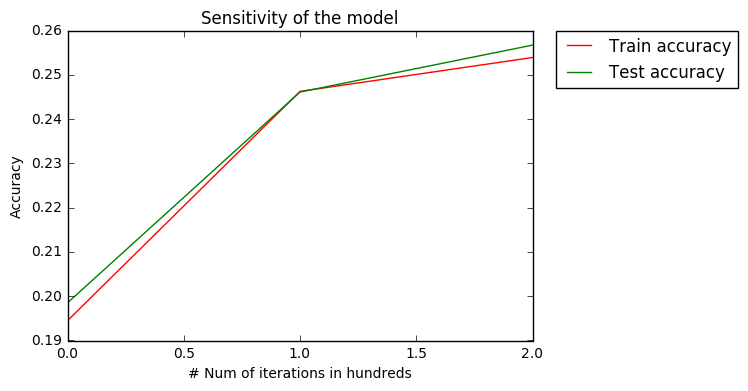

In [139]:
# 6.2. 4.5 Sensitivity of the model's performance to different number of iterations !!

test_proportion = 0.2
X_train, X_test, y_train, y_test = split_data(X,y,test_proportion)
j = 0
train_acc = []
test_acc = []
for i in range(10, 300, 100):
    W,b,loss = my_own_batch_sgd(X_train,y_train,0.0001,0.1,i)
    #W,b,loss = linear_classifier(X_train,y_train,0.0001,0.1,i)
    # Performance check
    y_hat_train = np.argmax((np.dot(X_train, W)+b), axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    
    y_hat_test = np.argmax((np.dot(X_test, W)+b), axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    #print("# of Iterations = ",i," | Accuracy train = ",training_precision, " | Accuracy test = ",test_precision)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("# Num of iterations in hundreds")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

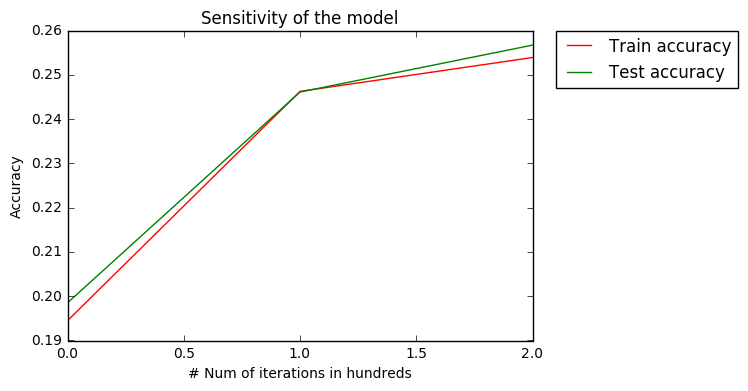

In [140]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("# Num of iterations in hundreds")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

iteration: 0  loss: 2.47884706651
iteration: 10  loss: 2.39260629366
iteration: 20  loss: 2.3757995553
iteration: 30  loss: 2.36948409609
iteration: 40  loss: 2.36706879203
iteration: 0  loss: 157.375961581
iteration: 10  loss: 21.109849056
iteration: 20  loss: 4.67511308214
iteration: 30  loss: 2.70440140074
iteration: 40  loss: 2.47189104868
iteration: 0  loss: 311.934244348
iteration: 10  loss: 5.92270345769
iteration: 20  loss: 2.43544824073
iteration: 30  loss: 2.39632648387
iteration: 40  loss: 2.39587996781
iteration: 0  loss: 460.151367768
iteration: 10  loss: 2.76261579822
iteration: 20  loss: 2.4000289848
iteration: 30  loss: 2.39898899116
iteration: 40  loss: 2.39913585117


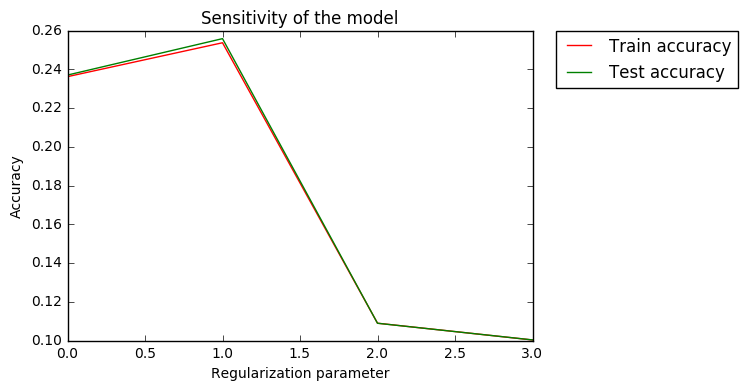

In [50]:
#6.2 4.6. What is the sensitivity of the model's performance to different regularization parameter values

j = 0
train_acc = []
test_acc = []
for i in range(1, 4000, 1000):
    W,b,loss = my_own_batch_sgd(X_train,y_train,i/1000,0.1,50)
    #W,b,loss = linear_classifier(X_train,y_train,i/1000,1.7,1000)
    # Performance check
    y_hat_train = np.argmax((np.dot(X_train, W)+b), axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    
    y_hat_test = np.argmax((np.dot(X_test, W)+b), axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    #print("# of Iterations = ",i," | Accuracy train = ",training_precision, " | Accuracy test = ",test_precision)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)
    
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Regularization parameter in 10 ^-3")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [51]:
# 6.1.4.7 What is the sensitivity of the model's performance with respect to a different test-train split (50%:50%).
test_proportion = 0.5
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

D = X_train.shape[1]     # 28*28
k = int(max(y_train)+ 1) # 10
W = 0.1*np.random.randn(D,k)   # How do you declare a D*K matrix ??? Be careful !!!
b = 0.1*np.zeros((1,k))
W,b,loss = linear_classifier(X_train,y_train,W,b,0.0001,0.1,50)    
    # Performance check
    
y_hat_train = np.argmax((np.dot(X_train, W)+b), axis = 1)
training_precision = np.mean(y_hat_train == y_train)

y_hat_test = np.argmax((np.dot(X_Val, W)+b), axis = 1)
test_precision = np.mean(y_hat_test == y_Val)
    
#print("batch: ",i, " | Loss: ",loss)
#print("### Exiting batch execution")
print("Accuracy train = ",training_precision," | test = ",test_precision)


(25000, 3073) (25000,)
iteration: 0  loss: 2.34383583413
iteration: 10  loss: 2.25132288459
iteration: 20  loss: 2.23240351023
iteration: 30  loss: 2.22355424043
iteration: 40  loss: 2.21848536069
Accuracy train =  0.2362  | test =  0.23256


# #* Two Layer Network*


In [161]:
def two_layer_ffnn(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,iterate):
    
    #reg = 0.0001
    #learning_rate = 0.1
    for i in range(iterate):
        hidden_layer = np.maximum(0,np.dot(X_train,W1)+ b1)
        scores = np.dot(hidden_layer,W2)+ b2
        
        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
        # compute the loss: average cross-entropy loss and regularization
        loss = logistic_loss(W2,b2,hidden_layer,y_train) + 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        #if i % 100 == 0:
            #print("iteration: ", i, " loss = ",loss)
        num_examples = len(X_train)
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples
        # backpropate the gradient to the parameters (W,b)
        dW2 = np.dot(hidden_layer.T, dscores)         # is W equal to 'a' ref Week0 slides >>> dh/da * dg/dh
        db2 = np.sum(dscores, axis=0, keepdims=True)  
        dhidden = np.dot(dscores, W2.T)
        dhidden[hidden_layer <= 0] = 0
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        dW2 += reg * W2
        dW1 += reg * W1
        # perform a parameter update
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
    return W1, b1, W2, b2, loss;

In [162]:
def my_own_batch_sgd_ffn(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 32
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W1 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b1 = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(hid_lyr_neurons,k)   
    b2 = np.zeros((1,k))
    batch_size = 50
    print("### Entering batch execution")
    for i in range(0,batch_size):
        #print("batch: ",i)
        start = int((X_train.shape[0]/50)*i)
        end = int((X_train.shape[0]/50)*(i+1))
        W1, b1, W2, b2, loss = two_layer_ffnn(X_train[start:end,],y_train[start:end,],W1,b1,W2,b2,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W1, b1, W2, b2, loss;

In [163]:
def get_train_accuracy_ffn(X_train,y_train,W1,b1,W2,b2):
    y_hat_train = np.argmax(np.dot(np.maximum(0,np.dot(X_train,W1)+ b1),W2)+ b2,axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    print("Accuracy Train : ",training_precision)
    return training_precision;

def get_test_accuracy_ffn(X_test,y_test,W1,b1,W2,b2):
    y_hat_test = np.argmax(np.dot(np.maximum(0,np.dot(X_test,W1)+ b1),W2)+ b2, axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    print("Accuracy Test  : ",test_precision)
    return test_precision;

In [164]:
# 6.2.  5.1.1

test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,0,0.1,100)

get_train_accuracy_ffn(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn(X_Val,y_Val, W1, b1, W2, b2)

(40000, 3073) (40000,)
### Entering batch execution
### Exiting batch execution  |  Loss = 2.07360442315
Accuracy Train :  0.42525
Accuracy Test  :  0.4015


0.40150000000000002

In [122]:
# 6.2. 5.1.4.4 Cross validation justification 

from sklearn import cross_validation
cv = cross_validation.KFold(len(X_train), n_folds=3, shuffle=True) # 43200 & 4800 each
i = 0
for train_indices, test_indices in cv:
    i = i + 1  
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train[train_indices],y_train[train_indices],0.0001,0.1,100)
    y_hat_test = np.argmax(np.dot(np.maximum(0,np.dot(X_train[test_indices],W1)+ b1),W2)+ b2, axis = 1)
    test_precision = np.mean(y_hat_test == y_train[test_indices])
    print("#### CV ", i)
    print("test = ",test_precision)

### Entering batch execution
### Exiting batch execution  |  Loss = 2.08692868806
#### CV  1
test =  0.339932805376
### Entering batch execution
### Exiting batch execution  |  Loss = 2.09655635439
#### CV  2
test =  0.354374174967
### Entering batch execution
### Exiting batch execution  |  Loss = 2.12443162476
#### CV  3
test =  0.316932677307


In [141]:
# What is the sensitivity of the model's performance to different learning rates
# the number of gradient descent iterations. Describe via suitable plots.

test_proportion = 0.2
X_train, X_test, y_train, y_test = split_data(X,y,test_proportion)
j = 0
train_acc = []
test_acc = []
for i in range(10, 300, 100):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,0.0001,0.1,i)
    
    # Performance check
    training_precision= get_train_accuracy_ffn(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)


(40000, 3073) (40000,)
### Entering batch execution
### Exiting batch execution  |  Loss = 2.11155151349
Accuracy Train :  0.3563
Accuracy Test  :  0.3526
### Entering batch execution
### Exiting batch execution  |  Loss = 2.08577570859
Accuracy Train :  0.43215
Accuracy Test  :  0.3963
### Entering batch execution
### Exiting batch execution  |  Loss = 2.1468722148
Accuracy Train :  0.394325
Accuracy Test  :  0.3761


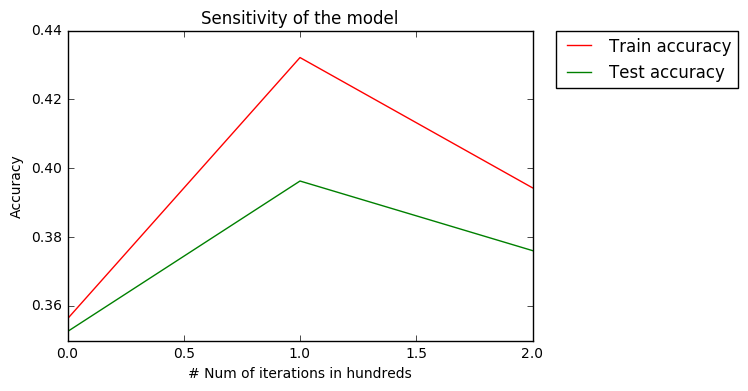

In [142]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("# Num of iterations in hundreds")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [123]:
j = 0
train_acc = []
test_acc = []
for i in range(100, 4000, 1000):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,0.0001,i/1000,50)
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_ffn(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

### Entering batch execution
### Exiting batch execution  |  Loss = 2.10354448342
Accuracy Train :  0.41012
Accuracy Test  :  0.3926
### Entering batch execution
### Exiting batch execution  |  Loss = 2.44396622373
Accuracy Train :  0.10092
Accuracy Test  :  0.103
### Entering batch execution
### Exiting batch execution  |  Loss = 3.33638496459
Accuracy Train :  0.10092
Accuracy Test  :  0.103
### Entering batch execution
### Exiting batch execution  |  Loss = 2.65096419592
Accuracy Train :  0.10092
Accuracy Test  :  0.103


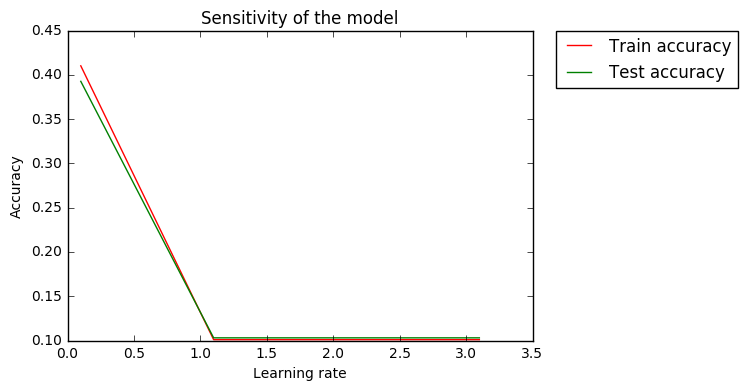

In [124]:
plt.plot(np.arange(0.1, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0.1, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [125]:

#j = 0
train_acc = []
test_acc = []
for i in range(1, 4000, 1000):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,i/1000,0.1,50)
    # Performance check
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_ffn(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)
    

### Entering batch execution
### Exiting batch execution  |  Loss = 2.09784148048
Accuracy Train :  0.41668
Accuracy Test  :  0.397
### Entering batch execution
### Exiting batch execution  |  Loss = 2.3001796998
Accuracy Train :  0.12832
Accuracy Test  :  0.1286
### Entering batch execution
### Exiting batch execution  |  Loss = 2.4309752149
Accuracy Train :  0.10136
Accuracy Test  :  0.0989
### Entering batch execution
### Exiting batch execution  |  Loss = 2.43097520409
Accuracy Train :  0.10136
Accuracy Test  :  0.0989


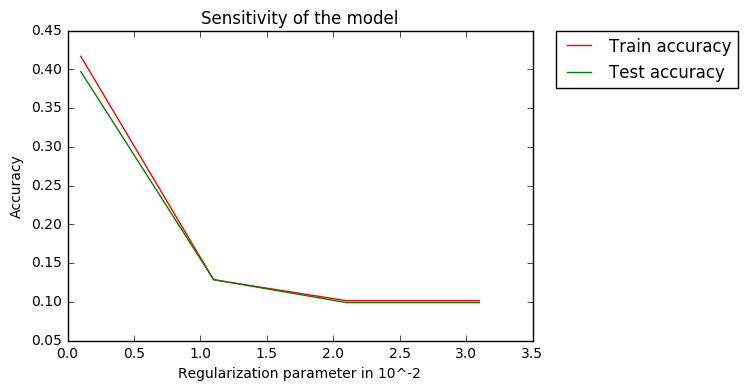

In [126]:
plt.plot(np.arange(0.1, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0.1, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Regularization parameter in 10^-2")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [69]:
test_proportion = 0.5
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn(X_train,y_train,0.0001,0.1,50)

get_train_accuracy_ffn(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn(X_Val,y_Val, W1, b1, W2, b2)

(25000, 3073) (25000,)
### Entering batch execution
### Exiting batch execution  |  Loss = 2.06675094873
Accuracy Train :  0.39468
Accuracy Test  :  0.36988


0.36987999999999999

# * Leaky Relu *

In [165]:
# 6.2.5.2
def two_layer_ffnn_leaky_relu(X_train,y_train,W1,b1,W2,b2,reg,learning_rate,iterate):

    #reg = 0.0001
    #learning_rate = 0.1
    for i in range(iterate):
                
        hidden_layer = np.dot(X_train,W1)+b1
        hidden_layer[hidden_layer<0] = 0.01*hidden_layer[np.where(hidden_layer<0)]
        
        scores = np.dot(hidden_layer,W2)+ b2
        
        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
        # compute the loss: average cross-entropy loss and regularization
        loss = logistic_loss(W2,b2,hidden_layer,y_train) + 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        #if i % 10 == 0:
            #print("iteration: ", i, " loss = ",loss)
        num_examples = len(X_train)
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples
        # backpropate the gradient to the parameters (W,b)
        dW2 = np.dot(hidden_layer.T, dscores)         # is W equal to 'a' ref Week0 slides >>> dh/da * dg/dh
        db2 = np.sum(dscores, axis=0, keepdims=True)  
        dhidden = np.dot(dscores, W2.T)
        dhidden[hidden_layer < 0] = 0.01*dhidden[np.where(hidden_layer<0)]  # Doubt ???
        dW1 = np.dot(X_train.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        dW2 += reg * W2
        dW1 += reg * W1
        # perform a parameter update
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
    return W1, b1, W2, b2, loss;

In [166]:
def my_own_batch_sgd_ffn_leaky(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 32
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W1 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b1 = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(hid_lyr_neurons,k)   
    b2 = np.zeros((1,k))
    batch_size = 50
    print("### Entering batch execution")
    for i in range(0,batch_size):
        #print("batch: ",i)
        start = int((X_train.shape[0]/50)*i)
        end = int((X_train.shape[0]/50)*(i+1))
        W1, b1, W2, b2, loss = two_layer_ffnn_leaky_relu(X_train[start:end,],y_train[start:end,],W1,b1,W2,b2,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W1, b1, W2, b2, loss;

In [167]:
def get_test_accuracy_ffn_leaky(X_test,y_test,W1,b1,W2,b2):
    hidden_layer = np.dot(X_test,W1)+b1
    hidden_layer[hidden_layer<0] = 0.01*hidden_layer[np.where(hidden_layer<0)]
    y_hat_test = np.argmax((np.dot(hidden_layer, W2) + b2),axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    print("Accuracy Test : ",test_precision)
    return test_precision;
    
def get_train_accuracy_ffn_leaky(X_train,y_train,W1,b1,W2,b2):
    hidden_layer = np.dot(X_train,W1)+b1
    hidden_layer[hidden_layer<0] = 0.01*hidden_layer[np.where(hidden_layer<0)]
    y_hat_train = np.argmax((np.dot(hidden_layer, W2) + b2),axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    print("Accuracy Train : ",training_precision)
    return training_precision;

In [160]:
test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0,0.1,50)

get_train_accuracy_ffn_leaky(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn_leaky(X_Val,y_Val, W1, b1, W2, b2)

(40000, 3073) (40000,)
### Entering batch execution
### Exiting batch execution  |  Loss = 2.0588315451
Accuracy Train :  0.428425
Accuracy Test :  0.4026


0.40260000000000001

In [120]:
from sklearn import cross_validation
cv = cross_validation.KFold(len(X_train), n_folds=3, shuffle=True) # 43200 & 4800 each
i = 0
for train_indices, test_indices in cv:
    i = i + 1  
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train[train_indices],y_train[train_indices],0.0001,0.1,50)
    hidden_layer = np.dot(X_train[test_indices],W1)+b1
    hidden_layer[hidden_layer<0] = 0.01*hidden_layer[np.where(hidden_layer<0)]
    y_hat_test = np.argmax(np.dot(np.maximum(0,np.dot(X_train[test_indices],W1)+ b1),W2)+ b2, axis = 1)
    test_precision = np.mean(y_hat_test == y_train[test_indices])
    print("#### CV ", i)
    print("test = ",test_precision)

### Entering batch execution
### Exiting batch execution  |  Loss = 2.00177852197
#### CV  1
test =  0.347252219822
### Entering batch execution
### Exiting batch execution  |  Loss = 2.05971886727
#### CV  2
test =  0.359534381375
### Entering batch execution
### Exiting batch execution  |  Loss = 2.05399699494
#### CV  3
test =  0.355334213369


In [146]:
# What is the sensitivity of the model's performance to different learning rates
# the number of gradient descent iterations. Describe via suitable plots.

test_proportion = 0.2
X_train, X_test, y_train, y_test = split_data(X,y,test_proportion)
j = 0
train_acc = []
test_acc = []
for i in range(10, 500, 100):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0001,0.1,i)
    
    # Performance check
    training_precision= get_train_accuracy_ffn_leaky(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn_leaky(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

(40000, 3073) (40000,)
### Entering batch execution
### Exiting batch execution  |  Loss = 2.12296586222
Accuracy Train :  0.3585
Accuracy Test :  0.3581
### Entering batch execution
### Exiting batch execution  |  Loss = 2.03964877959
Accuracy Train :  0.439225
Accuracy Test :  0.4199
### Entering batch execution
### Exiting batch execution  |  Loss = 2.11917250229
Accuracy Train :  0.416975
Accuracy Test :  0.3901
### Entering batch execution
### Exiting batch execution  |  Loss = 2.18128443561
Accuracy Train :  0.40135
Accuracy Test :  0.3782
### Entering batch execution
### Exiting batch execution  |  Loss = 2.21301766259
Accuracy Train :  0.362375
Accuracy Test :  0.3444


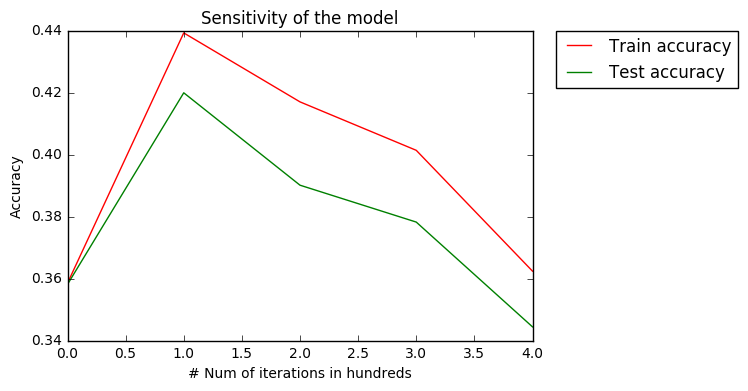

In [147]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("# Num of iterations in hundreds")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [115]:
#Gradient
j = 0
train_acc = []
test_acc = []
for i in range(100, 4000, 1000):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0001,i/1000,50)
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_ffn_leaky(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn_leaky(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)
    

### Entering batch execution
### Exiting batch execution  |  Loss = 2.05419930782
Accuracy Train :  0.42388
Accuracy Test :  0.3971
### Entering batch execution
### Exiting batch execution  |  Loss = nan
Accuracy Train :  0.09976
Accuracy Test :  0.1004
### Entering batch execution
### Exiting batch execution  |  Loss = nan
Accuracy Train :  0.09976
Accuracy Test :  0.1004
### Entering batch execution
### Exiting batch execution  |  Loss = nan
Accuracy Train :  0.09976
Accuracy Test :  0.1004


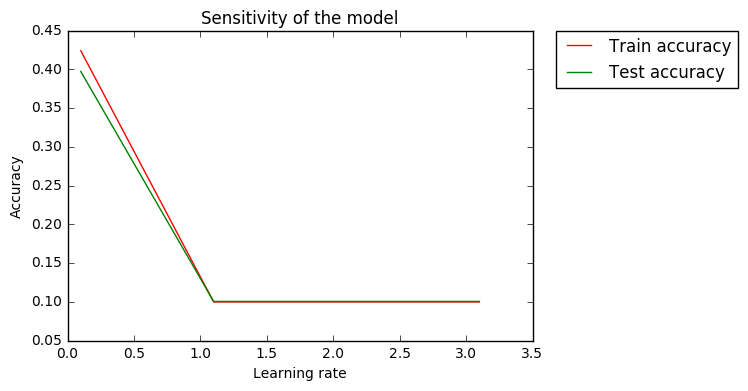

In [116]:
plt.plot(np.arange(0.1, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0.1, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [117]:
#Regularization
j = 0
train_acc = []
test_acc = []
for i in range(1, 4000, 1000):
    W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,i/1000,0.1,50)
    # Performance check
    # Performance check
    # Performance check
    training_precision= get_train_accuracy_ffn_leaky(X_train,y_train,W1,b1,W2,b2)
    test_precision= get_test_accuracy_ffn_leaky(X_test,y_test,W1,b1,W2,b2)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)
    

### Entering batch execution
### Exiting batch execution  |  Loss = 2.08034137317
Accuracy Train :  0.4206
Accuracy Test :  0.4011
### Entering batch execution
### Exiting batch execution  |  Loss = 2.30016386711
Accuracy Train :  0.12844
Accuracy Test :  0.1288
### Entering batch execution
### Exiting batch execution  |  Loss = 2.43097520866
Accuracy Train :  0.10136
Accuracy Test :  0.0989
### Entering batch execution
### Exiting batch execution  |  Loss = 2.43097520424
Accuracy Train :  0.10136
Accuracy Test :  0.0989


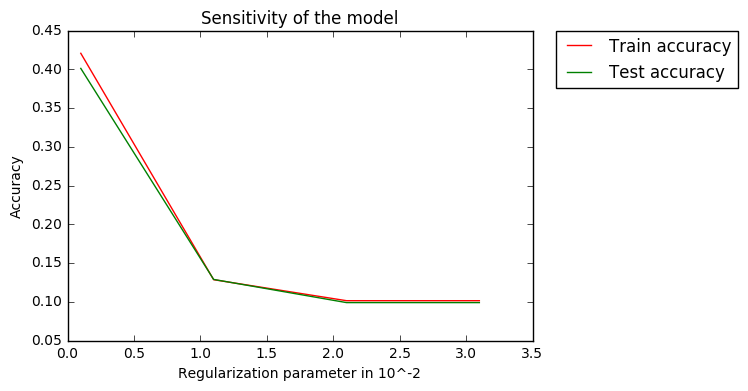

In [121]:
plt.plot(np.arange(0.1, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0.1, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Regularization parameter in 10^-2")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [168]:
test_proportion = 0.5
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W1, b1, W2, b2, loss = my_own_batch_sgd_ffn_leaky(X_train,y_train,0.0001,0.1,50)

get_train_accuracy_ffn_leaky(X_train,y_train,W1, b1, W2, b2)
get_test_accuracy_ffn_leaky(X_Val,y_Val, W1, b1, W2, b2)

(25000, 3073) (25000,)
### Entering batch execution
### Exiting batch execution  |  Loss = 2.03821689655
Accuracy Train :  0.38884
Accuracy Test :  0.36708


0.36708000000000002

# *Maxout*

In [169]:
def reg_log_loss_layer_maxout(x_train,y_train,W,b,W2,b2,W3,b3,reg,step_size,iterations):
    
    num_examples = x_train.shape[0]
    
    total_loss = np.zeros(iterations)
    for i in range(0, iterations):
    
        hidden_layer = np.dot(x_train, W) + b # note, ReLU activation
        hidden_layer1 = np.dot(x_train, W2) + b2
        scores = np.dot(np.maximum(hidden_layer, hidden_layer1), W3) + b3
    
    # compute the class probabilities
        exp_scores = np.exp(scores)
        scores = scores/scores.max()
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)# [N x K]
    #axis = 1 means row wise addition
    
        corect_logprobs = -np.log(probs[range(num_examples),y_train])
   
        data_loss = np.sum(corect_logprobs)/num_examples
        L2_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2) + 0.5*reg*np.sum(W3*W3)
        log_L2_loss = data_loss + L2_loss
        #log_L1_loss = data_loss + L1_loss
        #L1_loss = 0.5*reg*np.sum(np.absolute(W)) + 0.5*reg*np.sum(np.absolute(W2)) + 0.5*reg*np.sum(np.absolute(W3))
        total_loss[i]=log_L2_loss 
        #if i % 10 == 0:
            #print("iteration: ", i, " loss = ",log_L2_loss)
    # compute the gradient on scores
        dscores = probs
        dscores[range(num_examples),y_train] -= 1
        dscores /= num_examples
  
    # backpropate the gradient to the parameters (W,b)
        dW3 = np.dot(np.maximum(hidden_layer.T, hidden_layer1.T), dscores)
        db3 = np.sum(dscores, axis=0, keepdims=True) 
        
    # next backprop into hidden layer
        dhidden = np.dot(dscores, W3.T)
        dhidden1 = np.dot(dscores, W3.T)
    # backprop the ReLU non-linearity
        dhidden[hidden_layer1 < hidden_layer] = 0*dhidden[np.where(hidden_layer1 < hidden_layer)] #backpropogate the relu non-linearity or not
        dhidden1[hidden_layer1 > hidden_layer] = 0*dhidden[np.where(hidden_layer1 > hidden_layer)]
    # backpropate the gradient to the parameters (W,b)
        dW2 = np.dot(x_train.T, dhidden)
        db2 = np.sum(dhidden, axis=0, keepdims=True)
        
    # next backprop into hidden layer
        #dhidden1 = np.dot(dscores, x_train.T)
    # backprop the ReLU non-linearity
        #dhidden1[hidden_layer <= 0] = 0
        #dhidden = np.maximum(dhidden,dhidden1)
        
    # finally into W,b
        dW = np.dot(x_train.T, dhidden1)
        db = np.sum(dhidden1, axis=0, keepdims=True)
  
  
      # add regularization gradient contribution
        dW3 += reg * W3
        dW2 += reg * W2
        dW  += reg * W
  
     # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2
        W3 += -step_size * dW3
        b3 += -step_size * db3
    return W,b,W2,b2,W3,b3,total_loss;

In [170]:
def my_own_batch_sgd_ffn_maxout(X_train,y_train,reg,learning_rate,num_iter):
    hid_lyr_neurons = 32
    D = X_train.shape[1]
    k = int(max(y_train)+ 1)
    W = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b = np.zeros((1,hid_lyr_neurons))
    W2 = 0.01*np.random.randn(D,hid_lyr_neurons)   
    b2 = np.zeros((1,hid_lyr_neurons))
    W3 = 0.01 * np.random.randn(hid_lyr_neurons,k)
    b3 = np.zeros((1,k))
    batch_size = 50
    print("### Entering batch execution")
    for i in range(0,batch_size):
        #print("batch: ",i)
        start = int((X_train.shape[0]/50)*i)
        end = int((X_train.shape[0]/50)*(i+1))
        W,b,W2,b2,W3,b3,total_loss = reg_log_loss_layer_maxout(X_train[start:end,],y_train[start:end,],W,b,W2,b2,W3,b3,reg,learning_rate,num_iter)
    print("### Exiting batch execution  |  Loss =", loss)
    return W,b,W2,b2,W3,b3,total_loss;

In [171]:
def get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3):
    y_hat_train = np.argmax(np.dot(np.maximum(np.dot(X_train, W) + b, np.dot(X_train, W2) + b2), W3) + b3, axis = 1)
    training_precision = np.mean(y_hat_train == y_train)
    print("Accuracy Train : ",training_precision)
    return training_precision;

def get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3):
    y_hat_test = np.argmax(np.dot(np.maximum(np.dot(X_test, W) + b, np.dot(X_test, W2) + b2), W3) + b3, axis = 1)
    test_precision = np.mean(y_hat_test == y_test)
    print("Accuracy Test  : ",test_precision)
    return test_precision;

In [172]:
test_proportion = 0.2
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0,0.1,50)

get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)

(40000, 3073) (40000,)
### Entering batch execution
### Exiting batch execution  |  Loss = 2.03821689655
Accuracy Train :  0.427575
Accuracy Test  :  0.4006


0.40060000000000001

In [131]:
from sklearn import cross_validation
cv = cross_validation.KFold(len(X_train), n_folds=3, shuffle=True) # 43200 & 4800 each
i = 0
for train_indices, test_indices in cv:
    i = i + 1  
    W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train[train_indices],y_train[train_indices],0.01,0.1,50)
    y_hat_test = np.argmax(np.dot(np.maximum(np.dot(X_train[test_indices], W) + b, np.dot(X_train[test_indices], W2) + b2), W3) + b3, axis = 1)
    test_precision = np.mean(y_hat_test == y_train[test_indices])
    print("#### CV ", i)
    print("test = ",test_precision)
    

### Entering batch execution
### Exiting batch execution  |  Loss = 2.75944913169
#### CV  1
test =  0.333813294936
### Entering batch execution
### Exiting batch execution  |  Loss = [ 2.04995428  1.96210914  1.96225069  1.98591193  2.03625496  1.97981139
  1.90816961  1.87532198  1.85825986  1.85209658  2.07230175  2.2812121
  2.06172019  1.8587259   1.85679811  1.75659361  1.68183313  1.66055374
  1.629161    1.64364825  1.69903668  1.80052165  1.73788564  1.72614312
  1.68708104  1.60500553  1.56808345  1.53701154  1.50291214  1.49823716
  1.50621559  1.53436752  1.54017774  1.56464255  1.54315177  1.51684346
  1.54323056  1.54094997  1.50534452  1.53096244  1.49298484  1.51131321
  1.52738864  1.56626269  1.57192251  1.44988742  1.47432307  1.43665725
  1.40973379  1.36309045]
#### CV  2
test =  0.347053882155
### Entering batch execution
### Exiting batch execution  |  Loss = [ 2.18678349  2.21825256  2.31928603  2.13930496  2.00662045  1.98318871
  1.93991989  2.04083634  1.8548

In [138]:
# What is the sensitivity of the model's performance to different learning rates
# the number of gradient descent iterations. Describe via suitable plots.

test_proportion = 0.2
X_train, X_test, y_train, y_test = split_data(X,y,test_proportion)
j = 0
train_acc = []
test_acc = []
for i in range(10, 300, 100):
    W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0001,0.1,i)
    # Performance check
    training_precision = get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
    test_precision = get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

(40000, 3073) (40000,)
### Entering batch execution
### Exiting batch execution  |  Loss = [ 2.30769853  2.30746474  2.30723551  2.30701076  2.30679039  2.30657432
  2.30636247  2.30615474  2.30595107  2.30575136  2.30555555  2.30536355
  2.3051753   2.30499071  2.30480972  2.30463226  2.30445825  2.30428763
  2.30412033  2.30395629  2.30379545  2.30363773  2.30348308  2.30333144
  2.30318275  2.30303696  2.302894    2.30275382  2.30261636  2.30248158
  2.30234942  2.30221982  2.30209275  2.30196814  2.30184596  2.30172615
  2.30160866  2.30149346  2.30138049  2.30126972  2.30116109  2.30105457
  2.30095013  2.3008477   2.30074726  2.30064878  2.3005522   2.30045749
  2.30036462  2.30027355]
Accuracy Train :  0.3667
Accuracy Test  :  0.3633
### Entering batch execution
### Exiting batch execution  |  Loss = [ 1.83051296  1.7902616   1.75787583  1.74936389  1.74065348  1.73510689
  1.7343698   1.7349632   1.75064679  1.76773982]
Accuracy Train :  0.423975
Accuracy Test  :  0.3966
### En

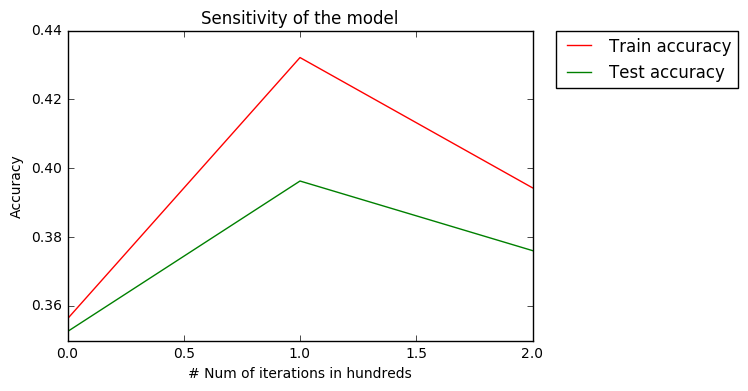

In [143]:
plt.plot(np.arange(0, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("# Num of iterations in hundreds")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [132]:
# Gradient
j = 0
train_acc = []
test_acc = []
for i in range(100, 4000, 1000):
    W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0001,i/1000,50)
    # Performance check
    training_precision = get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
    test_precision = get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

### Entering batch execution
### Exiting batch execution  |  Loss = [ 2.14153263  2.04874181  2.04639671  2.05544498  1.882727    1.85332649
  1.81005591  1.81548623  1.79442357  1.8155937   1.80774152  1.8215068
  1.81043994  1.78920816  1.76159059  1.71539348  1.7200684   1.70611037
  1.70880812  1.69624072  1.67683799  1.65503585  1.61823134  1.59353767
  1.57046428  1.55609882  1.55406263  1.55911685  1.62215335  1.62513994
  1.60867759  1.55698382  1.52390826  1.52648922  1.57184609  1.49678978
  1.51717995  1.45298583  1.46652643  1.42979181  1.4397987   1.46130894
  1.44897179  1.49123864  1.4451909   1.41099208  1.43235957  1.44134753
  1.44092572  1.41758683]
Accuracy Train :  0.44268
Accuracy Test  :  0.4102
### Entering batch execution
### Exiting batch execution  |  Loss = [ 1.86593582  1.77840532  1.71949662  1.6860053   1.66617725  1.63092183
  1.61409175  1.58145199  1.57223794  1.55485223  1.54242434  1.53266917
  1.51193554  1.5094908   1.48470229  1.4810317   1.456190

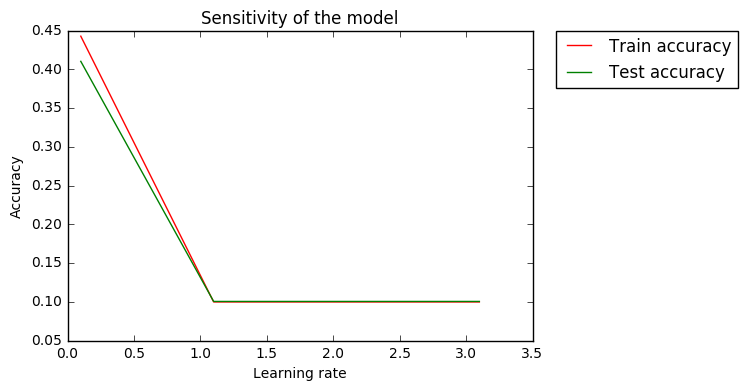

In [133]:
plt.plot(np.arange(0.1, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0.1, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [136]:
j = 0
train_acc = []
test_acc = []
for i in range(1, 4000, 1000):
    W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,i/1000,0.1,50)
    # Performance check
    training_precision = get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
    test_precision = get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)
    
    train_acc.append(training_precision)
    test_acc.append(test_precision)

### Entering batch execution
### Exiting batch execution  |  Loss = [ 1.93746249  1.83140108  1.8040941   1.7018719   1.66734112  1.63318686
  1.6148736   1.59255585  1.59024477  1.59371602  1.61277748  1.63704662
  1.64495175  1.61837756  1.5883805   1.55366787  1.51586148  1.48491414
  1.46287482  1.44388275  1.423985    1.40762306  1.39402861  1.38436298
  1.37258053  1.37094354  1.36445139  1.3879295   1.38626276  1.4556831
  1.43654477  1.45677079  1.40143252  1.3654691   1.32574156  1.32033282
  1.30260889  1.2967865   1.28870352  1.28982357  1.30736271  1.30053286
  1.33760859  1.33235138  1.32419747  1.30040676  1.25891387  1.23891083
  1.22882013  1.22184135]
Accuracy Train :  0.42356
Accuracy Test  :  0.4069
### Entering batch execution
### Exiting batch execution  |  Loss = [ 1.90198122  1.82565359  1.77584949  1.74989127  1.73038937  1.6823827
  1.69883799  1.65651482  1.69692508  1.6815559   1.69900847  1.67698429
  1.6570848   1.6228285   1.57542817  1.55485496  1.5190378

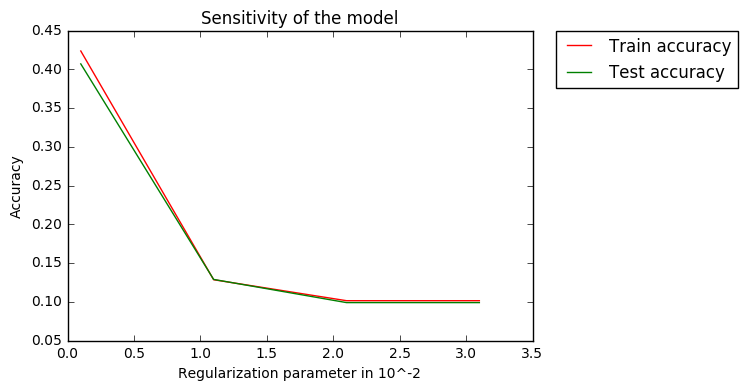

In [137]:
plt.plot(np.arange(0.1, len(train_acc)),train_acc,'r',label = "Train accuracy") 
plt.plot(np.arange(0.1, len(train_acc)),test_acc,'g',label = "Test accuracy")
plt.xlabel("Regularization parameter in 10^-2")
plt.ylabel("Accuracy")
plt.title("Sensitivity of the model")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.text(100, max(train_acc[2])-max(train_acc[2]/10), 'Test accuracy' ,color = 'green')
#plt.text(100, max(train_acc[2])-max(train_acc[2]/8), 'Train accuracy' ,color = 'red')
plt.show()

In [109]:
test_proportion = 0.5
X_train, X_Val, y_train, y_Val = split_data(X,y,test_proportion)

W, b, W2, b2, W3, b3, loss = my_own_batch_sgd_ffn_maxout(X_train,y_train,0.0001,0.1,50)

get_train_accuracy_maxout(X_train,y_train,W, b, W2, b2, W3, b3)
get_test_accuracy_maxout(X_test,y_test,W, b, W2, b2, W3, b3)

(25000, 3073) (25000,)
### Entering batch execution
### Exiting batch execution  |  Loss = [ 2.25398952  2.24530858  2.23514126  2.23268473  2.22834847  2.22788916
  2.22521131  2.22565266  2.22373002  2.22476471  2.22308768  2.22458662
  2.22290622  2.22477942  2.22298217  2.2251276   2.22304679  2.22536786
  2.22304132  2.22541872  2.22269915  2.22495573  2.22216856  2.22427329
  2.22138687  2.22335302  2.22057579  2.2224524   2.22001215  2.2218999
  2.21959409  2.22155896  2.21946518  2.22148135  2.21949123  2.22166592
  2.21959305  2.22186726  2.21980925  2.2221676   2.21988705  2.22225328
  2.2199069   2.22228765  2.21983124  2.22215976  2.21961716  2.22191264
  2.21938456  2.22164161]
Accuracy Train :  0.43544
Accuracy Test  :  0.4048


0.40479999999999999